In [1]:
import warnings
warnings.filterwarnings('ignore')

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/working ViT/")
sys.path.append(f"{os.getcwd()}/mltfm/")
from VisionTransformer_working import VisionTransformer as vit_old

2023-01-12 11:08:14.071139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 11:08:14.281614: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 11:08:14.281637: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 11:08:14.325476: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-12 11:08:14.882069: W tensorflow/stream_executor/platform/de

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


## Idea

Optimization for a linear combination of similar tasks often yields models that are more accurate, generalize better and require less training data. A possible multi-task objective for TFM could be
<h3><center>$\mathcal{L} = \alpha_{1}$$\cdot MSE + \alpha_{2}$$\cdot DTMA + \alpha_{3}$$\cdot DDA$</center></h3>
where
<h3><center>$\boldsymbol\alpha > 0, \space\space\sum_{i=1}^{3} \alpha_{i} = 1$</center></h3>


Try model trained on multi-task objective.

In [10]:
vit_multi = vit_old(dspl_size=104,
                  patch_size=8,
                  embed_dim=128,
                  depth=12,
                  n_heads=8,
                  mlp_ratio=4.,
                  p=0.,
                  attn_p=0.,
                  drop_path=0.).float()

In [13]:
path_to_multi_pth = '/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/working ViT/logs_and_weights/ViT-2023-Jan-09 11:57:14/ViT-2023-Jan-09 11:57:14_best_val_loss_0.003215498429.pth'

In [14]:
if torch.cuda.is_available():
    vit_multi.load_state_dict(torch.load(path_to_multi_pth)['best_model_weights'], strict=True)
else:
    vit_multi.load_state_dict(torch.load(path_to_multi_pth, map_location=torch.device('cpu'))['best_model_weights'], strict=True)        

In [15]:
dspl = np.array(h5py.File(f'data/extended data/allDisplacements.h5')['dspl'])
trac_separated = np.array(h5py.File(f'data/extended data/allTractions.h5')['trac'])

dspl = np.moveaxis(np.concatenate([dspl[i] for i in range(dspl.shape[0])], axis=0), 3, 1)
trac_separated = np.moveaxis(np.concatenate([trac_separated[i] for i in range(trac_separated.shape[0])], axis=0), 3, 1)

dspl_train = dspl[0:100, :, :, :]
dspl_val = dspl[100:110, :, :, :]
trac_train = trac_separated[0:100, :, :, :]
trac_val = trac_separated[100:110, :, :, :]

X_train = torch.from_numpy(dspl_train).float()
Y_train = torch.from_numpy(trac_train).float()
X_val = torch.from_numpy(dspl_val).float()
Y_val = torch.from_numpy(trac_val).float()

In [16]:
from MultiTask import multi_task_loss, dtma, dda, append_predictions_and_targets

In [17]:
vit_multi.eval()
loss = multi_task_loss
pred_vit_multi = vit_multi(X_train)

In [18]:
pred_vit_multi.shape

torch.Size([100, 2, 104, 104])

Text(0.5, 1.0, 'appended_targets')

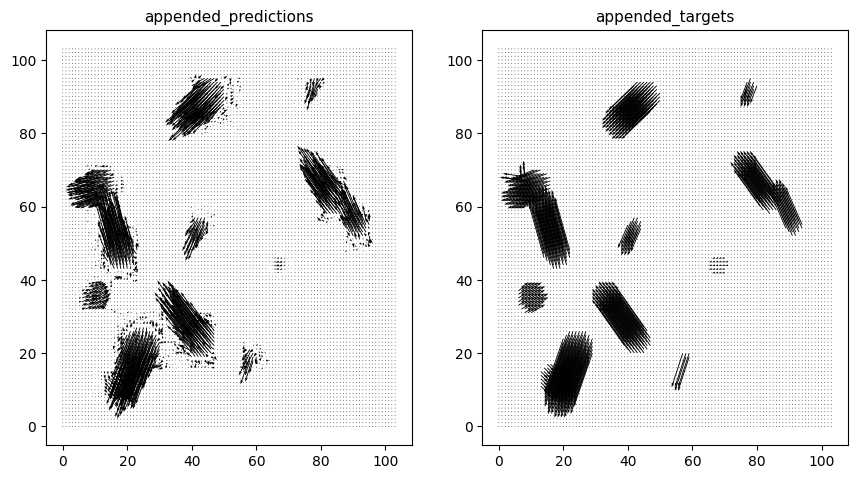

In [24]:
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(9, 5))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

axs[0].quiver(pred_vit_multi[0, 0, :, :].detach().numpy(), pred_vit_multi[0, 1, :, :].detach().numpy(), scale=3)
axs[0].set_title('appended_predictions', {'fontsize': 11})

axs[1].quiver(Y_train[0, 0, :, :], Y_train[0, 1, :, :], scale=3)
axs[1].set_title('appended_targets', {'fontsize': 11})

In [189]:
fig, axs = plt.subplots(50, 2, figsize=(10, 120))
fig.tight_layout(pad=2, w_pad=2, h_pad=2)

for i in range(50):
    axs[i, 0].quiver(appended_predictions[0, i, 0, :, :].detach().numpy(), appended_predictions[0, i, 1, :, :].detach().numpy(), scale=1)
    axs[i, 0].set_title('appended_predictions', {'fontsize': 11})

    axs[i, 1].quiver(appended_targets[0, i, 0, :, :], appended_targets[0, i, 1, :, :], scale=1)
    axs[i, 1].set_title('appended_targets', {'fontsize': 11})


<IPython.core.display.Javascript object>

In [202]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,2, figsize=(8, 8))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0, 0, :, :], X_test[0, 1, :, :], scale=1)
axs[0].set_title('PointForcemeshes[0]', {'fontsize': 11})

trac_test = torch.sum(trac_separated_test, dim=1)

axs[1].quiver(X_test[10, 0, :, :], X_test[10, 1, :, :], scale=1)
axs[1].set_title('PointForcemeshes[1]', {'fontsize': 11})

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'PointForcemeshes[1]')

In [203]:
vit_weights = vit_old(dspl_size=104,
                      patch_size=8,
                      embed_dim=128,
                      depth=12,
                      n_heads=8,
                      mlp_ratio=4.,
                      p=0.,
                      attn_p=0.,
                      drop_path=0.).double()

In [204]:
path_to_pth = 'working ViT/logs_and_weights/ViT-2022-Dec-10 23:18:41/ViT-2022-Dec-10 23:18:41_best_val_loss_2.365828e-06.pth'

In [205]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load(path_to_pth)['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load(path_to_pth, map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

In [206]:
os.getcwd()

'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM'

In [207]:
dspl = h5py.File('data/extended data/displacements_1.h5')["data"]
trac_separated = h5py.File('data/extended data/sep_tractions_1.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl[0:50, :, :, :]),3 ,1)
trac_separated_ = np.moveaxis(np.array(trac_separated[0:50, :, :, :]), 4, 2)

X_test = torch.from_numpy(dspl_).double().to(device)
trac_separated_test = torch.from_numpy(trac_separated_).double().to(device)

In [208]:
print(X_test.shape)
print(trac_separated_test.shape)

torch.Size([50, 2, 104, 104])
torch.Size([50, 50, 2, 104, 104])


In [209]:
vit_weights.eval()
pred_vit = vit_weights(X_test[:, :, :, :])
# pred_cnn = cnn_weights.predict(dspl[0:50, :, :, :])

In [210]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(3,2, figsize=(8, 10))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0, 0].quiver(pleaase[0, :, :, 0], pleaase[0, :, :, 1], scale=5)
axs[0, 0].set_title('trac_separated_test[0, 0]', {'fontsize': 11})

plt.imshow(pleaase[0, :, :, 2], cmap='hot', interpolation='none')

axs[0, 1].plt.imshow(pleaase[0, :, :, 2], cmap='hot', interpolation='nearest')
axs[0, 1].set_title('appended_predictions[0, 0]', {'fontsize': 11})

axs[1, 0].quiver(trac_separated_test[0, 10, 0, :, :].detach().numpy(), trac_separated_test[0, 10, 1, :, :].detach().numpy(), scale=10)
axs[1, 0].set_title('trac_separated_test[0, 13, 0]', {'fontsize': 11})

axs[1, 1].quiver(trac_separated_test[0, 15, 0, :, :].detach().numpy(), trac_separated_test[0, 15, 1, :, :].detach().numpy(), scale=10)
axs[1, 1].set_title('trac_separated_test[0, 20, 0]', {'fontsize': 11})

axs[2, 0].quiver(trac_separated_test[0, 20, 0, :, :].detach().numpy(), trac_separated_test[0, 20, 0, :, :].detach().numpy(), scale=23)
axs[2, 0].set_title('Y_test[0, 49, 0]', {'fontsize': 11})

axs[2, 1].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=13)
axs[2, 1].arrow(43, 18, Y_test[0, 0, 43, 18], 1,fc='red')
axs[2, 1].set_title('pred_vit', {'fontsize': 11})

<IPython.core.display.Javascript object>

AttributeError: 'AxesSubplot' object has no attribute 'plt'

In [16]:
tryout = h5py.File('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/data/extended data/try_displacements_1.h5')

In [17]:
tryout['data']

<HDF5 dataset "data": shape (1, 104, 104, 2), type "<f8">

In [569]:
dtma_ex = dtma(appended_predictions, trac_separated_test)

In [570]:
dtma_ex

tensor(-0.0355, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [550]:
trac_separated_test[:,:].shape

torch.Size([10, 50, 2, 104, 104])

In [549]:
dtma_ex

tensor([-0.0254, -0.0162, -0.0254, -0.0178, -0.0254, -0.0323, -0.0222, -0.0237,
        -0.0197, -0.0296], grad_fn=<MulBackward0>)

In [546]:
pred_vit.shape

torch.Size([10, 2, 104, 104])

In [547]:
trac_separated_test.shape

torch.Size([10, 50, 2, 104, 104])

<IPython.core.display.Javascript object>


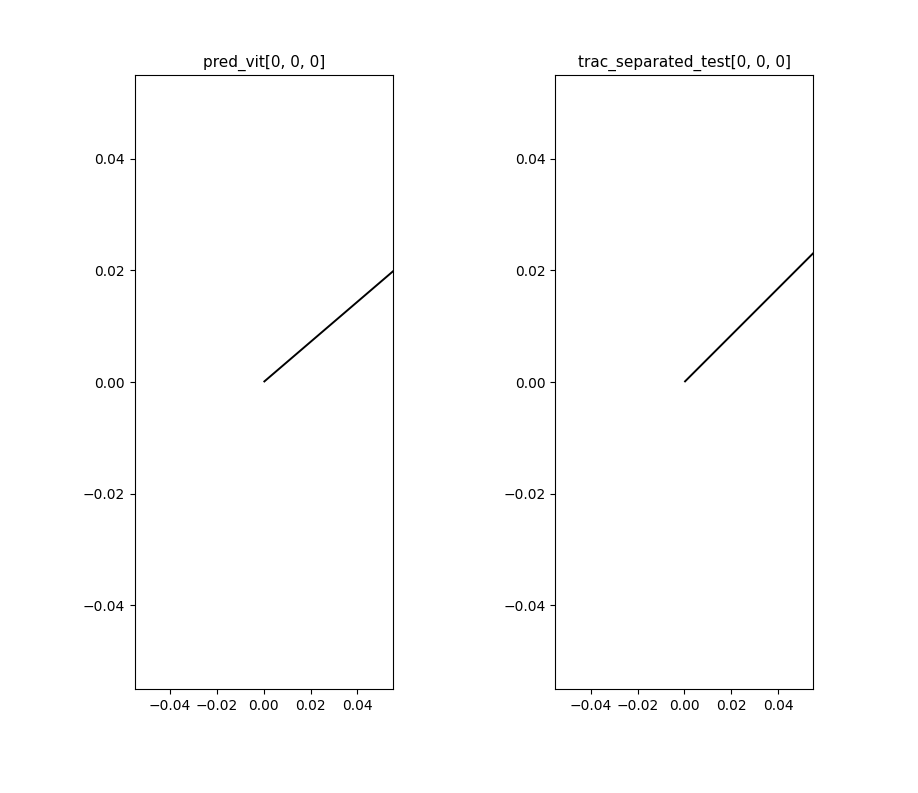

Text(0.5, 1.0, 'trac_separated_test[0, 0, 0]')

In [748]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1, 2, figsize=(5, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(pred_vit[0, 0, 35, 12].detach().numpy(), pred_vit[0, 1, 35, 12].detach().numpy(), scale=0.05)
axs[0].set_title('pred_vit[0, 0, 0]', {'fontsize': 11})

axs[1].quiver(Y_test[0, 0, 35, 12].detach().numpy(), Y_test[0, 0, 35, 12].detach().numpy(), scale=0.05)
axs[1].set_title('trac_separated_test[0, 0, 0]', {'fontsize': 11})

In [4]:
os.getcwd()

'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM'

In [20]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
event_acc = EventAccumulator('/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/working ViT/logs_and_weights/ViT-2023-Jan-09 11:57:14')
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

{'images': [], 'audio': [], 'histograms': [], 'scalars': ['train_loss', 'train_dtma', 'train_dda', 'val_loss', 'val_dtma', 'val_dda'], 'distributions': [], 'tensors': [], 'graph': True, 'meta_graph': False, 'run_metadata': ['step1']}


In [25]:
event_acc.Scalars(tag='train_loss')

[ScalarEvent(wall_time=1673272640.192751, step=1, value=0.007054788991808891),
 ScalarEvent(wall_time=1673283487.45204, step=2, value=0.006824362091720104),
 ScalarEvent(wall_time=1673294319.5199404, step=3, value=0.006650865077972412),
 ScalarEvent(wall_time=1673305168.320957, step=4, value=0.0065580205991864204),
 ScalarEvent(wall_time=1673316010.0302908, step=5, value=0.006416361778974533)]

In [5]:
writer = SummaryWriter(log_dir=f'/home/alexrichard/PycharmProjects/UQ_DL-TFM/ViT-TFM/working ViT/logs_and_weights/ViT-2023-Jan-11 10:36:58')

In [7]:
writer['train_loss']

TypeError: 'SummaryWriter' object is not subscriptable